In [1]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

Modules to reload:
all-except-skipped

Modules to skip:

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import os
import sys 
from pathlib import Path
root_path = Path(os.path.abspath(".."))
print(root_path)
if root_path.as_posix() not in sys.path: 
    sys.path.insert(0, root_path.as_posix())

/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import re
from astropy.table import Table


plt.rc('text', usetex=True)

In [4]:
from src import money
from src import weights 
from src import maps 


In [5]:
def plot_matrix(matrix, param_names):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)
    n, _ = matrix.shape  # assume square matrix
    plt.xticks(list(plt.xticks()[0]), [None] + param_names)
    plt.yticks(list(plt.yticks()[0]), [None] + param_names)

    plt.tick_params(labelsize=20)

    ax.matshow(matrix, cmap=plt.cm.Blues)

    for i in range(n):
        for j in range(n):
            c = matrix[j, i]
            ax.text(i, j, '{:.2g}'.format(c), va='center', ha='center', size=20)


In [6]:
data_dir = root_path.joinpath("data")
temp_dir = data_dir.joinpath("temp") # save some data temporarily

print("The path for storing data is:", data_dir.as_posix())
print("Directory for caching and storing data from this notebook is:", temp_dir.as_posix())
temp_dir.mkdir(parents=True, exist_ok=True)

The path for storing data is: /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD/data
Directory for caching and storing data from this notebook is: /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD/data/temp


# Simulate catalogs 

Before running any of the results, there is a fair deal of the simulations that need to be obtained. You will need to run the following commands (probably in a cluster): 

```
./bin/run_get_all_simulations.py --simulate --project project1
./bin/run_get_all_simulations.py --process --project project1

./bin/run_get_all_simulations.py --simulate --large --project project2
./bin/run_get_all_simulations.py --process --large --project project2
```

This command will create folders like 'project1LSST-g1_0-g2_0' where the results will be saved, then you will need to extract the 'final_fits.fits' file in each of these directories and put the ones in project1 in a directory called 'simulated_catalogs_small' and the ones from project2 in 'simulated_catalogs_large'. Something like this should work: 


In [9]:
def organize_small_cat():
    from src import utils 
    import subprocess
    import re 

    small_catalogs = utils.data_dir.joinpath('simulated_catalogs_small')
    small_catalogs.mkdir()

    for p in utils.data_dir.iterdir(): 
        if p.name.startswith('project1'):
            length = len('project1LSST')
            suffix = p.name[length:]
            final_fits_file = p.joinpath('final_fits.fits')
            final_file = small_catalogs.joinpath(f"cats{suffix}")
            
            subprocess.run(f"cp {final_fits_file} {final_file}")

# Read catalogues 

In [7]:
#filters to apply as reading the catalogue. 
pre_filters = [
    maps.get_non_duplicated_cat
]

#filters to be applied uniformly ignoring the selection effect. 
intermediate_filters=[
    maps.get_not_dropped_cat, #does not commute with the other ones, so do first. 
    maps.not_dropped, #redundant. 
    maps.low_cond,
]


final_filters = [
    maps.good, 
    maps.best,
]

In [8]:
def sort_cat_files(file_dir, template="cat-g1_{}-g2_0"):
    """
    Return list containing the file paths in the correct order. (Comparing number in {})
    """
    file_names = [f.name for f in file_dir.iterdir()]
    template_regex = template.format("(-?\w*)")
    output_names = [] 
    for fname in file_names:
        n = int(re.match(template_regex, fname).groups()[0])
        output_names.append((n, fname))
    
    output_names = sorted(output_names, key=lambda x: x[0])
    return [file_dir.joinpath(out[1]) for out in output_names]

In [47]:
def prepare_final_catalogs(pcats, zero_shear_idx, pre_filters, intermediate_filters, final_filters, 
                           cache_name=None):
    """ 
    
    Args: 
        pcats: Catalogs obtained directly from running the `all-process.py` file. 
               As expained in the docstring for that file and above. 
        zero_shear_idx(int): The index of the catalog in pcats that is zero sheared. 
        cache_name(str): Can optionally save catalog in a temp_dir. 
    """
    assert zero_shear_idx == int(np.median(range(len(pcats)))), "Should be the middle one."
    
    cached_dir = None
    if cache_name: 
        # save catalogs in temp directory so we don't have to filter every time. 
        cached_dir = temp_dir.joinpath(cache_name)
        if cached_dir.exists():
            fpaths = sort_cat_files(cached_dir,"fcat{}.fits")
            print([fpath.name for fpath in fpaths])
            return [Table.read(cached_dir.joinpath(fpath)) for fpath in fpaths]
                
    
    # first we apply the first set of filters that is mostly a sanity check, removing the galaxies that managed
    # get duplicated by being in two different "sections"
    cats = maps.get_filter_cats(pcats, pre_filters)
    
    # then we apply a second set of filters which gets the galaxies that were not dropped during the fisher matrix
    # inversion procedure, and whose fisher matrices do not have a really low condition number. 
    scats = maps.get_filter_cats(cats, intermediate_filters)
    
    # in the last step we need to be more careful, to avoid selection effects, we only apply the filters 
    # to the zero shear catalog, and then only return the galaxies (identified by their id) 
    # that pass this cut in this catalog. 
    fcat = maps.get_filter_cats([scats[zero_shear_idx]], final_filters).pop() # returns a list so get only one element.
    scats.pop(zero_shear_idx)
    scats.insert(zero_shear_idx,fcat) 
    
    fcats = maps.get_intersection_cats(scats)  # intersects cats based on galaxy id. 
    
    if cached_dir: 
        cached_dir.mkdir(exists_ok=False)
        for i, fcat in enumerate(fcats): 
            fcat.write(f'fcat{i}.fits')

## read only catalogs between g=-0.02 and g=+0.02

In [48]:
pcats = [] 
print(f"Check order is expected:")
for cat_file in sort_cat_files(data_dir.joinpath("simulated_catalogs_small")):
    print(f"{cat_file.name}")
    pcats.append(
        Table.read(cat_file)
    )

Check order is expected:
cat-g1_-20-g2_0.fits
cat-g1_-15-g2_0.fits
cat-g1_-10-g2_0.fits
cat-g1_-5-g2_0.fits
cat-g1_0-g2_0.fits
cat-g1_5-g2_0.fits
cat-g1_10-g2_0.fits
cat-g1_15-g2_0.fits
cat-g1_20-g2_0.fits


In [49]:
fcats = prepare_final_catalogs(pcats, 4, pre_filters, intermediate_filters, final_filters, 
                               cache_name="fcats_small")

NameError: name 'pre_filters' is not defined

In [ ]:

fcat1 = maps.get_filter_cats([scats2[4]], ffilters).pop()
print(len(fcat1))
scats2.pop(6)
scats2.insert(6, fcat1) 
print(len(scats2))

In [10]:
fcats = [Table.read( f"data/fcats/fcat{i}.fits") for i in range(9)]
[len(cat) for cat in fcats]

[112574, 112574, 112574, 112574, 112574, 112574, 112574, 112574, 112574]

## read catalogs between g=-0.1 and g=+0.1

In [33]:
pcats2 = [
        Table.read(f"{data_dir}/fprojectLSST-g1_-100-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-50-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-20-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-15-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-10-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-5-g2_0/final_fits.fits"),
        Table.read(f"{data_dir}/fprojectLSST-g1_0-g2_0/final_fits.fits"), #i=6
        Table.read(f"{data_dir}/fprojectLSST-g1_5-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_10-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_15-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_20-g2_0/final_fits.fits"),
        Table.read(f"{data_dir}/fprojectLSST-g1_50-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_100-g2_0/final_fits.fits"), 
        ]

In [53]:
cats2 = maps.get_filter_cats(pcats2, pfilters) 
[len(cat) for cat in cats2]

[801340,
 801976,
 802149,
 802075,
 802121,
 802182,
 802101,
 802074,
 802166,
 802013,
 802031,
 801794,
 801133]

In [54]:
scats2 = maps.get_filter_cats(cats2, afilters)
[len(cat) for cat in scats2]

[798609,
 798387,
 798603,
 798493,
 798538,
 798477,
 798386,
 798376,
 798460,
 798309,
 798198,
 798345,
 797509]

In [55]:
fcat1 = maps.get_filter_cats([scats2[6]], ffilters)[0]
print(len(fcat1))
scats2.pop(6)
scats2.insert(6, fcat1) 
print(len(scats2))

112840
13


In [12]:
# #remember to not apply filters directly on cat2, but intersect
# fcats2 = maps.get_intersection_cats(scats2)

# [len(cat) for cat in fcats2]

NameError: name 'scats2' is not defined

In [57]:
# subprocess.run("mkdir data/fcats2", shell=True)
# for i,cat in enumerate(fcats2): 
#     cat.write( f"data/fcats2/fcat{i}.fits", "fits" )
    

In [9]:
fcats2 = [Table.read( f"data/fcats2/fcat{i}.fits") for i in range(13)]
[len(cat) for cat in fcats2]

[111394,
 111394,
 111394,
 111394,
 111394,
 111394,
 111394,
 111394,
 111394,
 111394,
 111394,
 111394,
 111394]

# Histograms of ab_mag

In [12]:
def histograms_abmag(cat,good):
    plt.rc('text', usetex=True)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    

    plt.hist(cat['ab_mag'], histtype='step', bins=18,color='blue',label='all galaxies',range=(20,29))
    plt.hist(good['ab_mag'], histtype='step',bins=18,color='red',label='lensing sample galaxies',range=(20,29))

    labels = [r'$0$',r'$10$',r'$20$',r'$30$',r'$40$']
    values = [0,10,20,30,40]
    conversion = 3600
    y = [value*conversion for value in values]
    plt.yticks(y, labels)
    
    
    plt.xlim((20,29))
    plt.ylabel(r'\rm Galaxies / sq. arcmin. / (0.5 mag)', fontsize=25)
    plt.xlabel(r'\rm Catalog AB magnitude',fontsize=25)
#     plt.title('Histogram of ab_mag for good galaxies')
    plt.legend(loc=2,prop={'size':20})
    plt.axvline(25.3,color='goldenrod',label='cut for golden sample') #this represents the gold sample cut.
    plt.xticks(size=20)
    plt.yticks(size=20)
#     ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.get_yaxis().get_offset_text().set_size(1)

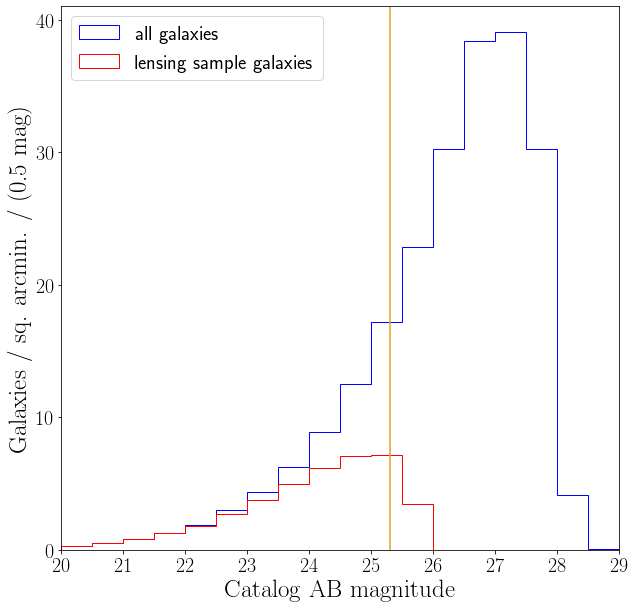

In [13]:
histograms_abmag(cats[4], maps.good(cats[4]))

# Histograms bias

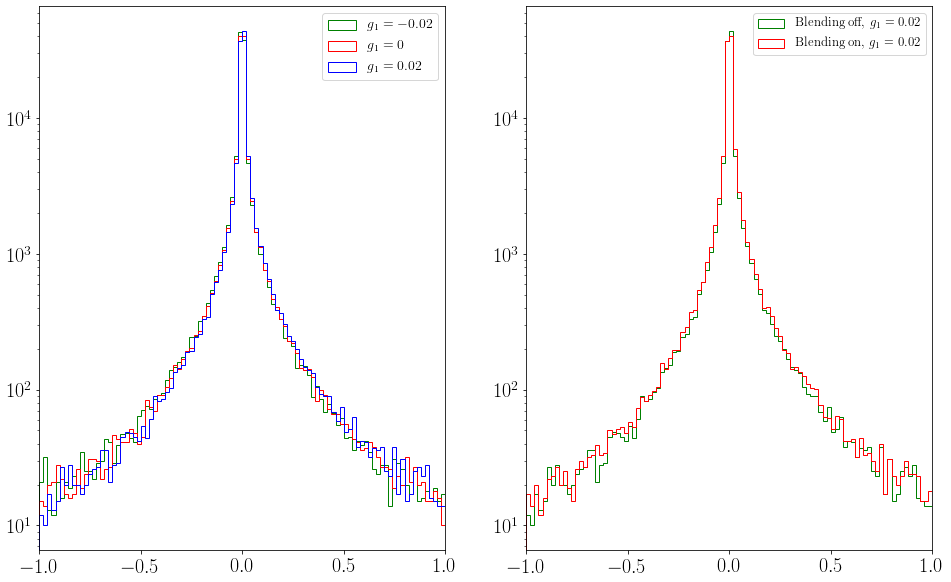

In [22]:
plt.rc('text', usetex=True)

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(16,10))
ax1,ax2 = axs.flatten()

ax1.hist(fcats[0]['bias_g1'], histtype='step', range=[-1,1], bins=100, label='$g_{1}=-0.02$', color='g');
ax1.hist(fcats[4]['bias_g1'], histtype='step', range=[-1,1], bins=100, label='$g_{1}=0$', color='r');
ax1.hist(fcats[-1]['bias_g1'], histtype='step', range=[-1,1], bins=100, label='$g_{1}=0.02$', color='b');
ax1.set_yscale("log")
ax1.legend(prop={'size':14})
ax1.set_xlim(-1,1)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.hist(fcats[-1]['bias_g1'], histtype='step', range=[-1,1], bins=100, label='\\rm Blending off, $g_{1}=0.02$', color='g');
ax2.hist(fcats[-1]['bias_g1_grp'], histtype='step', range=[-1,1], bins=100, label='\\rm Blending on, $g_{1}=0.02$', color='r');
ax2.set_yscale("log")
ax2.legend(prop={'size':13})
ax2.set_xlim(-1,1)
ax2.tick_params(axis='both', which='major', labelsize=20)


# Scatter plot 

In [43]:
#produce different plots with the biases calculated from the fisher formalism. 
plt.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


def purity_snr_scatter_final(fraction,analyze_cat,colors,power,full_cat,ax,name,save=None):
    #divide into 4 groups 

    high_pur_high_snr = maps.up_cut(maps.up_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    high_pur_low_snr = maps.down_cut(maps.up_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    low_pur_high_snr = maps.up_cut(maps.down_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    low_pur_low_snr = maps.down_cut(maps.down_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    
    #calculate percentages 
    p1 = float(len(high_pur_high_snr))/len(analyze_cat)
    p2 = float(len(high_pur_low_snr))/len(analyze_cat)
    p3 = float(len(low_pur_high_snr))/len(analyze_cat)
    p4 = float(len(low_pur_low_snr))/len(analyze_cat)
    
    #create smaller catalogues to plot them and reduce the density of points in each region. 
    small_hphs = maps.small(high_pur_high_snr,int(len(high_pur_high_snr)* fraction))
    small_hpls = maps.small(high_pur_low_snr,int(len(high_pur_low_snr)* fraction))
    small_lphs = maps.small(low_pur_high_snr,int(len(low_pur_high_snr) * fraction))
    small_lpls = maps.small(low_pur_low_snr,int(len(low_pur_low_snr)* fraction))

    x_new_ticks = [6,12,18,24,30]
    tex_x_new_ticks = [r'$6$',r'$12$',r'$18$',r'$24$',r'$30$']

    y_orig_ticks = np.array([0.,0.142,0.5402,.785,1])
    y_new_ticks = []
    for label in y_orig_ticks: 
        y_new_ticks.append(r'${:.2g}$'.format(label**(1./12)))
    
    #plot each group separately with different colors 
    #replace original ticks with of new ones. Do that for all. 
    plt.scatter(small_hphs['snr_grpf'],small_hphs['purity']**(power),alpha=.2,color=colors[0])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)
    
    plt.scatter(small_hpls['snr_grpf'],small_hpls['purity']**(power),alpha=.2,color=colors[1])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)

    plt.scatter(small_lphs['snr_grpf'],small_lphs['purity']**(power),alpha=.2,color=colors[2])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)
    
    plt.scatter(small_lpls['snr_grpf'],small_lpls['purity']**(power),alpha=.2,color=colors[3])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)

    #annotate with colors the percentages
    plt.annotate("{0:.1f}\%".format(p1*100), xy=(0.540, 0.885), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p2*100), xy=(0.040, 0.885), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p3*100), xy=(0.540, 0.4), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p4*100), xy=(0.040, 0.4), xycoords='axes fraction',color='black',fontsize=30)
    plt.text(.380,.01,r'Fraction of full catalogue:${0:.1f}$\%'.format(float(len((analyze_cat)))/len(full_cat)*100),transform=ax.transAxes,fontsize=25)
    
    

    plt.xlabel(r'$\nu_{\rm grpf}$',fontsize=40)
    plt.ylabel(r'$\rho$',fontsize=40)
    plt.tick_params(axis='x', which='major',labelsize=25,size=10,width=3)
    plt.tick_params(axis='y', which='major',labelsize=25,size=10,width=3)
    plt.xlim(0,30)
    plt.ylim(0.,1.)
    #plt.title(name)

(0, 30)

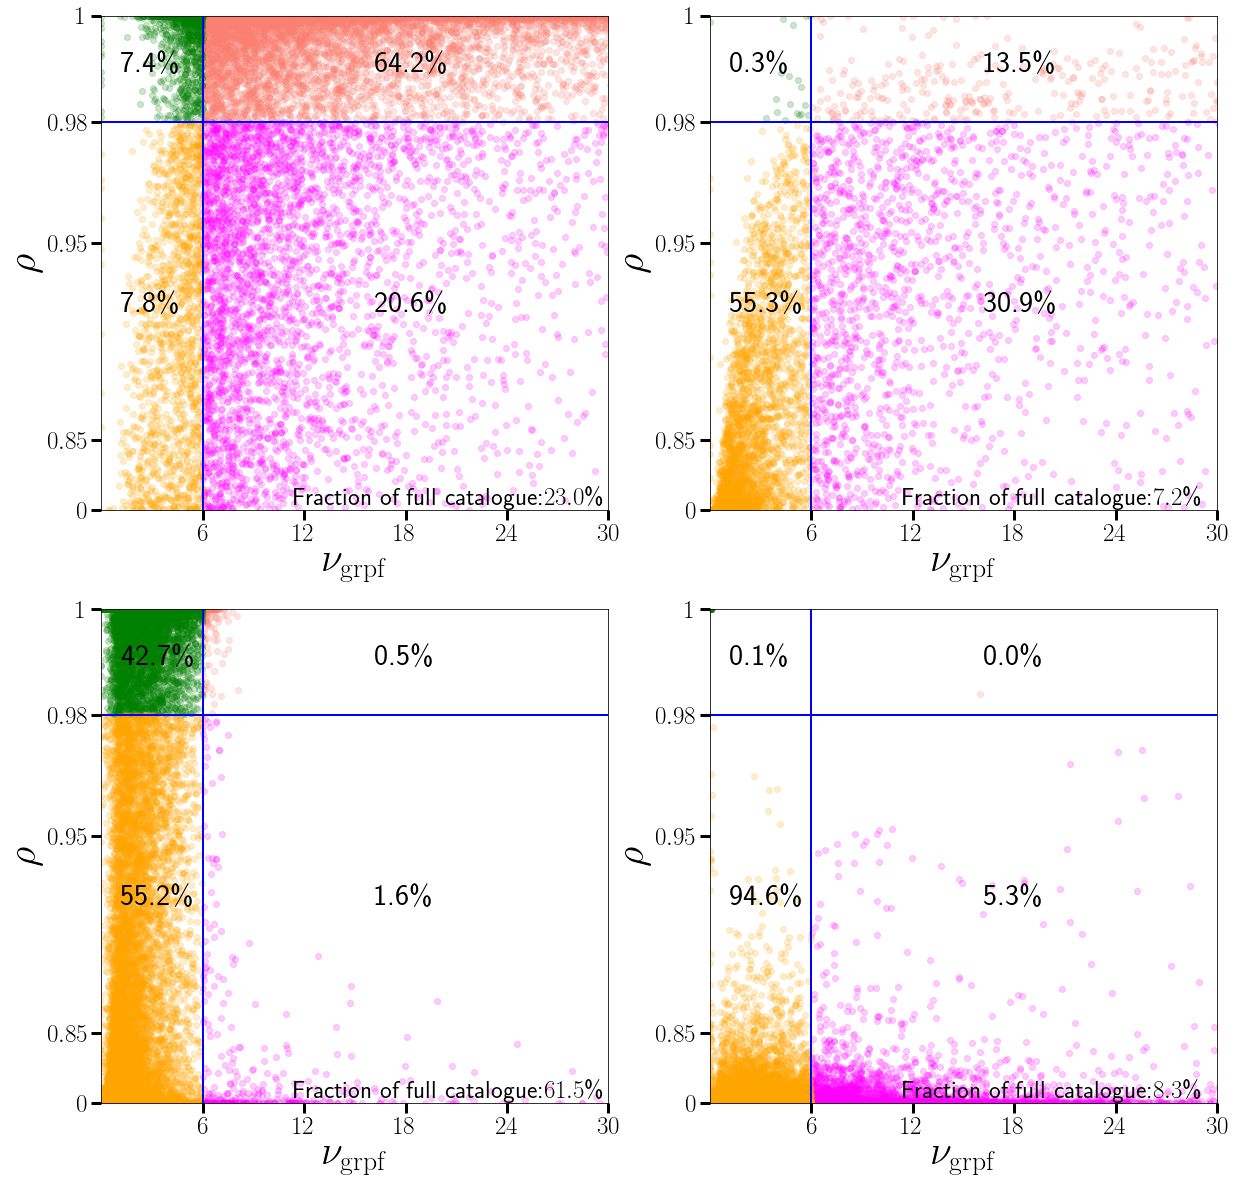

In [44]:
fig = plt.figure(figsize=(20,20))
nrow,ncol = 2,2
power = 12. 
scatter_cat = cats[4]

analyze_cats=[maps.detc_and_notambig(scatter_cat),maps.detc_and_ambig(scatter_cat),maps.notdetc_and_notambig(scatter_cat),
       maps.notdetc_and_ambig(scatter_cat)]
names = ['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig']
colors= ['salmon', 'green', 'magenta', 'orange','black']
fractions = [1/10.,1./10, 1./20, 1.] #exclusively for plotting purposes

for i,(name,temp_cat,fraction) in enumerate(zip(names,analyze_cats,fractions)):
    ax = plt.subplot(nrow, ncol, i+1)
    plt.axhline(.98**power,color='blue',linewidth=2)
    plt.axvline(6,color='blue',linewidth=2)
    purity_snr_scatter_final(fraction, temp_cat,colors,power,scatter_cat,ax,name)
    #as reference for debugging, 

plt.xlim(0,30)

# Weights vs. bias 

In [52]:
def weights_bias_scatter(ax, cat, component, iso_or_grp, xlabel=None, ylabel=None, title=None, xlim=(-5,5), 
                         size_dots=0.5, alpha=1): 
    orig_ids = list(range(len(cat)))
    ws = weights.get_weights(orig_ids, cat,  component, iso_or_grp, 'component')
    suffix = weights.get_iso_or_grp_suffix(iso_or_grp)

    ax.scatter(cat[f'bias_g{component}{suffix}'], ws, alpha=alpha, s=size_dots, c='b')
    #ax.set_title(title, size = 18 )
    ax.set_xlabel(xlabel, size=20)
    ax.set_ylabel(ylabel, size=20)
    ax.set_xlim(xlim)
    
    ax.tick_params(axis='both', which='major', labelsize=14)


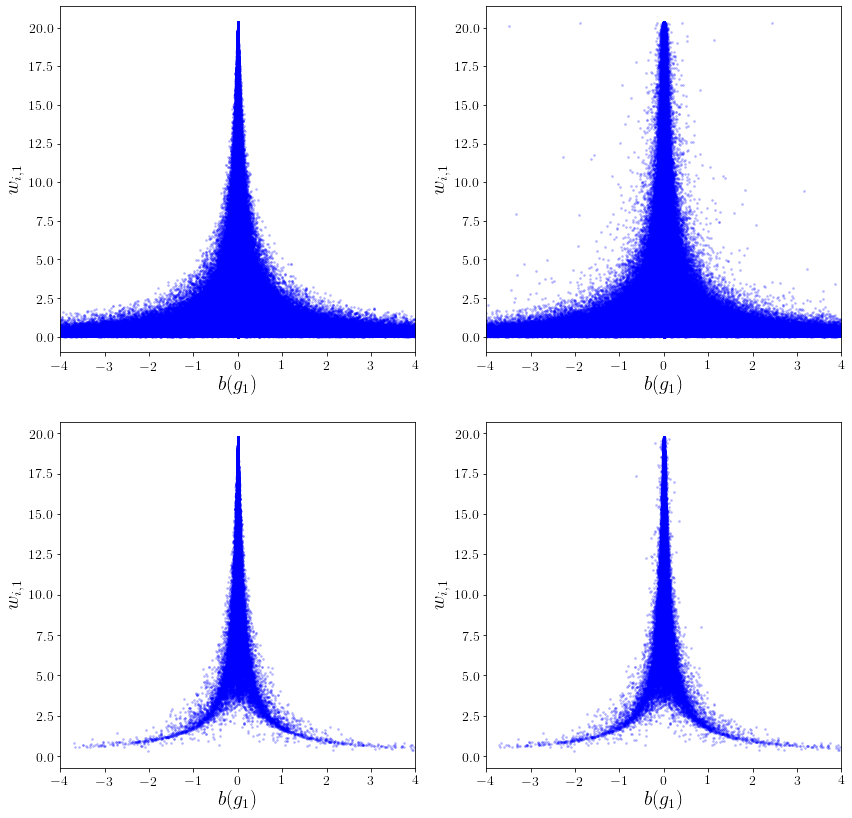

In [53]:
plt.rc('text', usetex=True)
fig, axs = plt.subplots(2,2,figsize=(14,14))
axes = axs.flatten()
weights_bias_scatter(axes[0], cats[8], '1', 'iso', xlim=[-4,4], size_dots=3, alpha=0.2, 
                     xlabel="$b(g_{1})$", ylabel="$w_{i,1}$", title="\\rm{All galaxies, blending off}")

weights_bias_scatter(axes[1], cats[8], '1', 'grp', xlim=[-4,4], size_dots=3, alpha=0.2, 
                     xlabel="$b(g_{1})$", ylabel="$w_{i,1}$", title="\\rm{All galaxies, blending on}")

weights_bias_scatter(axes[2], fcats[8], '1', 'iso', xlim=[-4,4], size_dots=3, alpha=0.2, 
                     xlabel="$b(g_{1})$", ylabel="$w_{i,1}$", title="\\rm{Detected and accurately deblended galaxies, blending on}")

weights_bias_scatter(axes[3], fcats[8], '1', 'grp', xlim=[-4,4], size_dots=3, alpha=0.2,
                     xlabel="$b(g_{1})$", ylabel="$w_{i,1}$", title="\\rm{Detected and accurately deblended galaxies, blending on}")

# Clipped means

In [57]:
def plot_clipped_means(ps, means1, errors1, means2, errors2, wmean1=None, error_wmean1=None,
                       wmean2=None, error_wmean2=None, ylims=None, plot_weighted=False, add_legend=False,
                      ylabel='\\rm sample mean noise bias'):
    
    plt.figure(figsize=(8,8))
    plt.rc('text', usetex=True)

    #plot errors
    plt.plot(ps, errors1, 'r+', markersize=8, label= 'error of mean g=0')
    plt.plot(ps, errors2, 'bx', markersize=8, label= 'error of means g=0.02')
    
    #plot the means. 
    plot_negpos(ps, means1, 'ro', {'markersize':8}, 'o', dict(markerfacecolor='None', color='r', markersize=8))
    plot_negpos(ps, means2, 'bo', {'markersize':8}, 'o', dict(markerfacecolor='None', color='b', markersize=8))
    
    if plot_weighted:
        #plot weighted means and errors 
        plt.axhline(np.absolute(wmean1), color='r') #negative. 
        plt.axhline(error_wmean1, color='r', linestyle='-.')

        plt.axhline(wmean2, color='b')
        plt.axhline(error_wmean2, color='b', linestyle='-.')

    
    if add_legend:
        add_custom_legend()

    plt.xlabel('\\rm{clipped quantile} $p$', size=30)
    plt.ylabel(ylabel, size=30)

    plt.yscale('log')

    plt.ylim(ylims)
    plt.tick_params(axis='both', which='major', labelsize=24)

    
def plot_negpos(ps, vals, marker_pos, kwargs_pos, marker_neg, kwargs_neg): 
    for p, val in zip(ps, vals):
        if val > 0: 
            plt.plot(p, val, marker_pos, **kwargs_pos)
        else: 
            plt.plot(p, np.absolute(val), marker_neg, **kwargs_neg)
            
def add_custom_legend():
    import matplotlib.lines as mlines

    empty, = plt.plot([], [], 'wo', markersize=7)



    blue_dot, = plt.plot([], [], 'bo', markersize=7)
#     blue_dot_nofill, = plt.plot([], [], "o", markerfacecolor='None', color='b', markersize=7)
    red_dot, = plt.plot([],[], 'ro', markersize=7)
#     red_dot_nofill,  = plt.plot([],[], "o", markerfacecolor='None', color='r', markersize=7)
    red_plus, = plt.plot([],[], "r+", markersize=7)
    blue_cross, = plt.plot([],[], "bx", markersize=7)

    black_line, = plt.plot([],[], 'k-')

    dotted_line, = plt.plot([],[], 'k-.')
# (red_dot_nofill, blue_dot_nofill)
#  "\\rm{Mean $<$ 0}",
    legend_artists = [empty, empty, (red_dot, blue_dot ), 
                      (red_plus, blue_cross), black_line, dotted_line ]
    legend_labels = ["\\rm{Red: blending off}", "\\rm{Blue: blending on}", "\\rm{Mean $>$ 0}", 
                     "\\rm{Error on mean}", "\\rm{Weighted mean}",
                     "\\rm{Error on weighted mean}"]
    leg = plt.legend(legend_artists, legend_labels, loc='lower left', numpoints=1,
                   handler_map={tuple: HandlerTuple(ndivide=None)}, prop={'size': 17})

    for i,text in enumerate(leg.get_texts()):

        if i==0: 
            plt.setp(text, color = 'r')
        elif i==1: 
            plt.setp(text, color = 'b')
        else: 
            break
            
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

def prepare_means_errors(ps, scat, clipped_mean,  N=1000, iso_args=[], grp_args=[]):
    """
    clipped_mean is a function that takes in a dbt, p
    clipped_mean_fnc is a function that only takes in p. 
    """
    
    orig_ids = list(range(len(scat)))
        
    means = [] 
    errors = [] 
    means_grp = [] 
    errors_grp = [] 
    

    
    for p in ps: 
        iso_nargs = [p] + iso_args
        grp_nargs = [p] + grp_args
        print("current p:", p)
        means.append(clipped_mean(orig_ids, scat, *iso_nargs))
        means_grp.append(clipped_mean(orig_ids, scat, *grp_nargs))
        print("calculating errors for p=", p)
        
        errs = weights.get_errors(orig_ids, [scat], clipped_mean, N=N, args=iso_nargs)
        errs_grp = weights.get_errors(orig_ids, [scat], clipped_mean, N=N, args=grp_nargs)
        errors.append(errs[0])
        errors_grp.append(errs_grp[0])
        
    return means, errors, means_grp, errors_grp

In [39]:
ps = np.linspace(0, 0.5, 51)

In [40]:
# means, errors, means_grp, errors_grp = prepare_means_errors(ps, fcats[-1], weights.clipped_mean)

In [41]:
# orig_ids = list(range(len(fcats[-1])))
# wmean = weights.wmean(orig_ids, fcats[-1], '1', 'iso', 'component')
# wmean_grp = weights.wmean(orig_ids, fcats[-1], '1', 'grp', 'component')

# err_wmean = weights.get_errors(orig_ids, [fcats[-1]], weights.wmean, N=1000, args=['1', 'iso', 'component'])[0]
# err_wmean_grp = weights.get_errors(orig_ids, [fcats[-1]], weights.wmean, N=1000, args=['1', 'grp', 'component'])[0]

In [51]:
# pickle.dump((means, errors, means_grp, errors_grp, wmean, wmean_grp, err_wmean, err_wmean_grp), 
#             open(os.path.join(data_dir, "fcats", "errors1.p"), 'wb') )
means, errors, means_grp, errors_grp, wmean, wmean_grp, err_wmean, err_wmean_grp = pickle.load(
open(os.path.join(data_dir, "fcats", "errors1.p"), 'rb'), encoding='latin1')

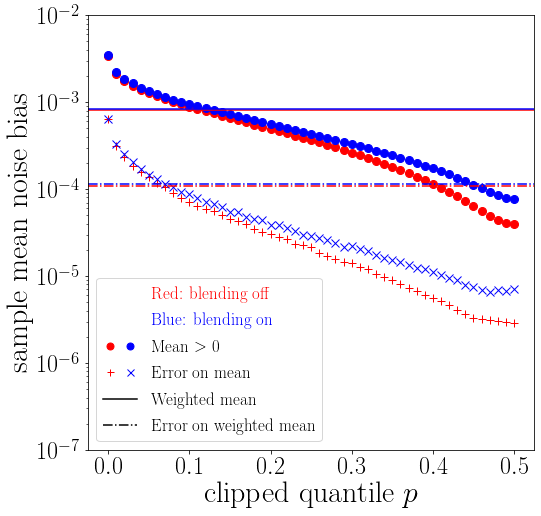

In [54]:
plot_clipped_means(ps, means, errors, means_grp, errors_grp, wmean, err_wmean, 
                   wmean_grp, err_wmean_grp, ylims=[1e-7,1e-2], plot_weighted=True, add_legend=True)

## weighted clipped means

In [55]:
#clipped weighted mean.
ps_small = np.linspace(0, 0.5, 26)
#cwmeans, cwerrors, cwmeans_grp, cwerrors_grps = prepare_means_errors(ps_small, fcats[-1], weights.clipped_weighted_mean, N=500, 
#                                                                iso_args=['bias_g1', '1', 'iso', 'component'], 
#                                                                grp_args=['bias_g1_grp', '1', 'grp', 'component'])
# pickle.dump((cwmeans, cwerrors, cwmeans_grp, cwerrors_grps), open(os.path.join(data_dir, "fcats", "cwerrors1.p"), "wb"))

In [56]:
cwmeans, cwerrors, cwmeans_grp, cwerrors_grps= pickle.load(open(os.path.join(data_dir, "fcats", 
                                                            "cwerrors1.p"), "rb"), encoding='latin1')

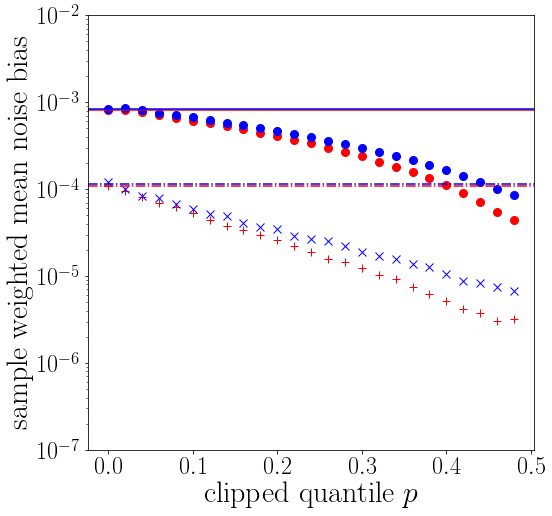

In [59]:
plot_clipped_means(ps_small, cwmeans, cwerrors, cwmeans_grp, cwerrors_grps, wmean, err_wmean, 
                   wmean_grp, err_wmean_grp, ylims=[1e-7,1e-2], 
                   plot_weighted=True, add_legend=False, ylabel="\\rm sample weighted mean noise bias")

# Money Plot, only shears from -0.02 and 0.02

In [10]:
g1s = np.array([-0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02])

In [11]:
orig_ids = list(range(len(fcats[0])))

## dump preps

In [ ]:
# median_prep = money.prepare_money_plot(g1s, orig_ids, fcats, weights.median_fnc, fit_procedure=money.chi_sq_fit, 
#                          N=int(1e4), model=money.linear_f, args_iso=['1', 'iso'], args_grp=['1', 'grp'])
# pickle.dump(median_prep, open("data/fmedian_prep.p", 'wb'))

In [ ]:
# weights_prep = money.prepare_money_plot(g1s, orig_ids, fcats, weights.wmean, fit_procedure=money.chi_sq_fit, 
#                                         N=int(1e4), model=money.linear_f, args_iso=['1', 'iso', 'component'], 
#                                         args_grp=['1', 'grp', 'component'])
# pickle.dump(weights_prep, open("data/fweights_prep.p", 'wb'))

In [24]:
# fcats1 = [cat[cat['grp_size']>1] for cat in fcats]
# fcats1 = maps.get_intersection_cats(fcats1)
# orig_ids2 = list(range(len(fcats1[0])))
# median_prep2 = money.prepare_money_plot(g1s, orig_ids2, fcats1, weights.median_fnc, fit_procedure=money.chi_sq_fit, 
#                          N=int(1e3), model=money.linear_f, args_iso=['1', 'iso'], args_grp=['1', 'grp'])
# weight_prep2 = money.prepare_money_plot(g1s, orig_ids2, fcats1, weights.wmean, fit_procedure=money.chi_sq_fit, 
#                                         N=int(1e3), model=money.linear_f, args_iso=['1', 'iso', 'component'], 
#                                         args_grp=['1', 'grp', 'component'])

# pickle.dump(median_prep2, open("data/fmedian_prep2.p", 'wb'))
# pickle.dump(weight_prep2, open("data/fweights_prep2.p", 'wb'))

## read preps

In [12]:
median_prep = pickle.load(open("data/fmedian_prep.p", 'rb'), encoding='latin1')
weights_prep = pickle.load(open("data/fweights_prep.p", 'rb'), encoding='latin1')

median2_prep = pickle.load(open("data/fmedian_prep2.p", 'rb'), encoding='latin1')
weights2_prep = pickle.load(open("data/fweights_prep2.p", 'rb'), encoding='latin1')

## plots

### all median

In [13]:
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median_prep
inv, inv_grp = np.linalg.inv(cov), np.linalg.inv(cov_grp)
print("Median noise bias for no applied shear (blending off): {:.3g}, error: {:.3g}".format(values[4], errs[4]))
print("Median noise bias for no applied shear (blending on): {:.3g}, error: {:.3g}".format(values_grp[4], errs_grp[4]))

Median noise bias for no applied shear (blending off): 1.24e-08, error: 2.73e-07
Median noise bias for no applied shear (blending on): -2.48e-06, error: 3.35e-06


Results for fits of unblended case: 


 value b0:     1.513e-03
error b0:     4.331e-05
value b1:     3.575e-07
error b1:     1.122e-07
error correlation coefficient: 9.949e-02

Results for fits of blended case: 


 value b0:     3.662e-03
error b0:     9.246e-05
value b1:     -5.557e-06
error b1:     1.757e-06
error correlation coefficient: -1.325e-01


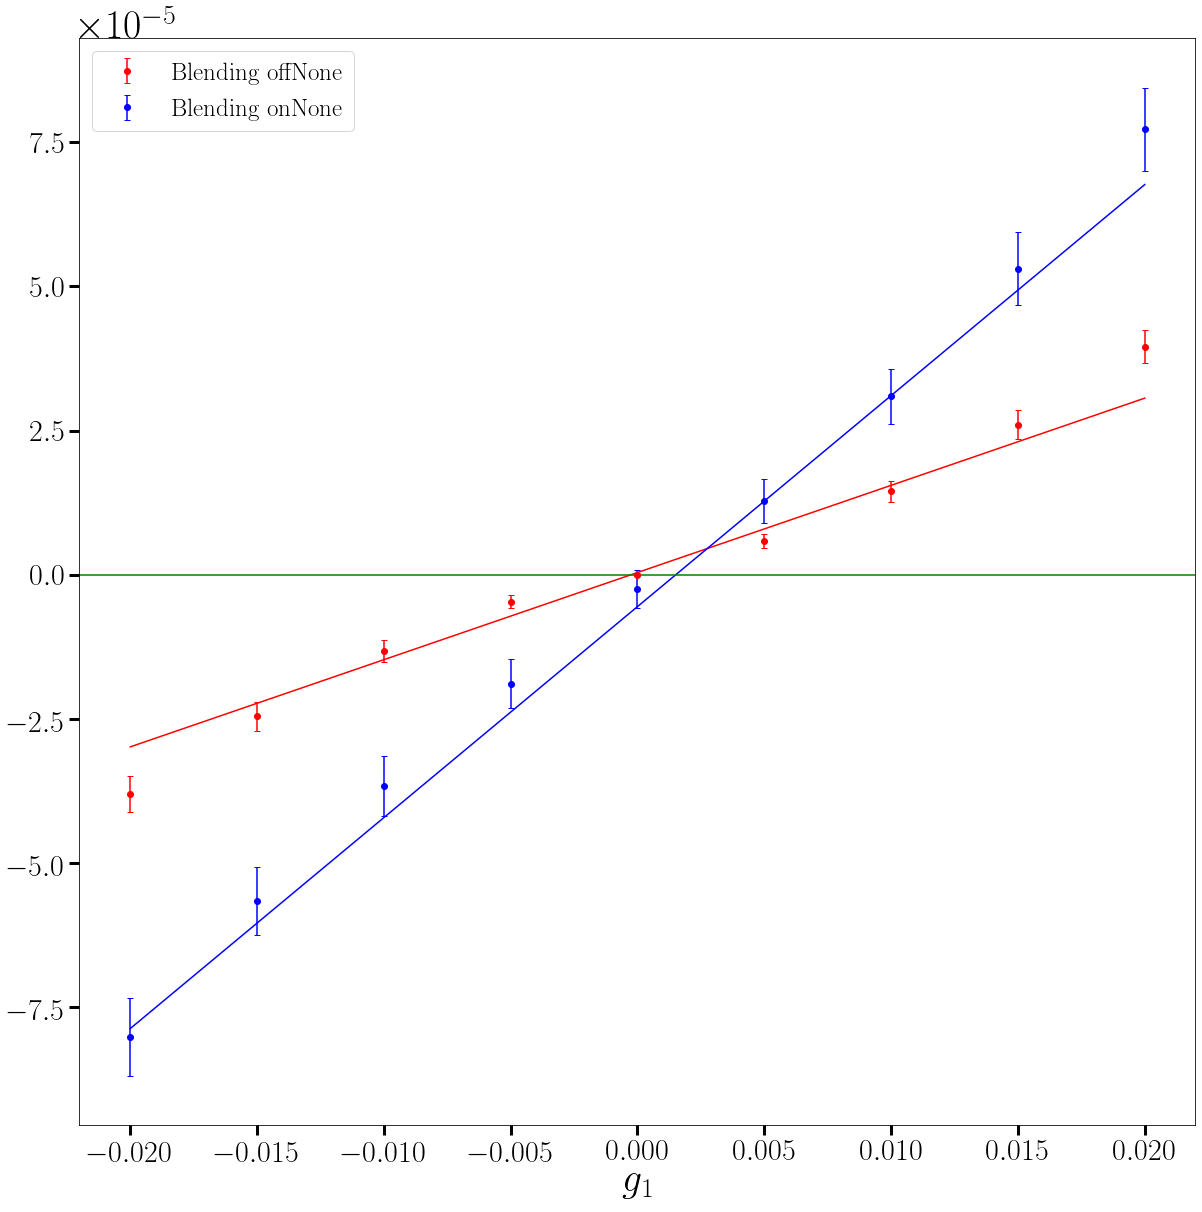

In [17]:
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, inv, inv_grp, ticks1=None, labely1=None)

### grp size > 1 median 

In [21]:
1+1

2

In [18]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [19]:
blue, orange, green, pink = CB_color_cycle[0],CB_color_cycle[1], CB_color_cycle[2], CB_color_cycle[3]

Results for fits of unblended case: 


 value b0:     1.513e-03
error b0:     4.331e-05
value b1:     3.575e-07
error b1:     1.122e-07
error correlation coefficient: 9.949e-02

Results for fits of blended case: 


 value b0:     3.662e-03
error b0:     9.246e-05
value b1:     -5.557e-06
error b1:     1.757e-06
error correlation coefficient: -1.325e-01

Results for fits of unblended case: 


 value b0:     1.058e-03
error b0:     3.374e-05
value b1:     4.642e-07
error b1:     1.138e-07
error correlation coefficient: 1.312e-01

Results for fits of blended case: 


 value b0:     2.712e-03
error b0:     7.620e-05
value b1:     -4.569e-06
error b1:     1.805e-06
error correlation coefficient: -1.913e-01


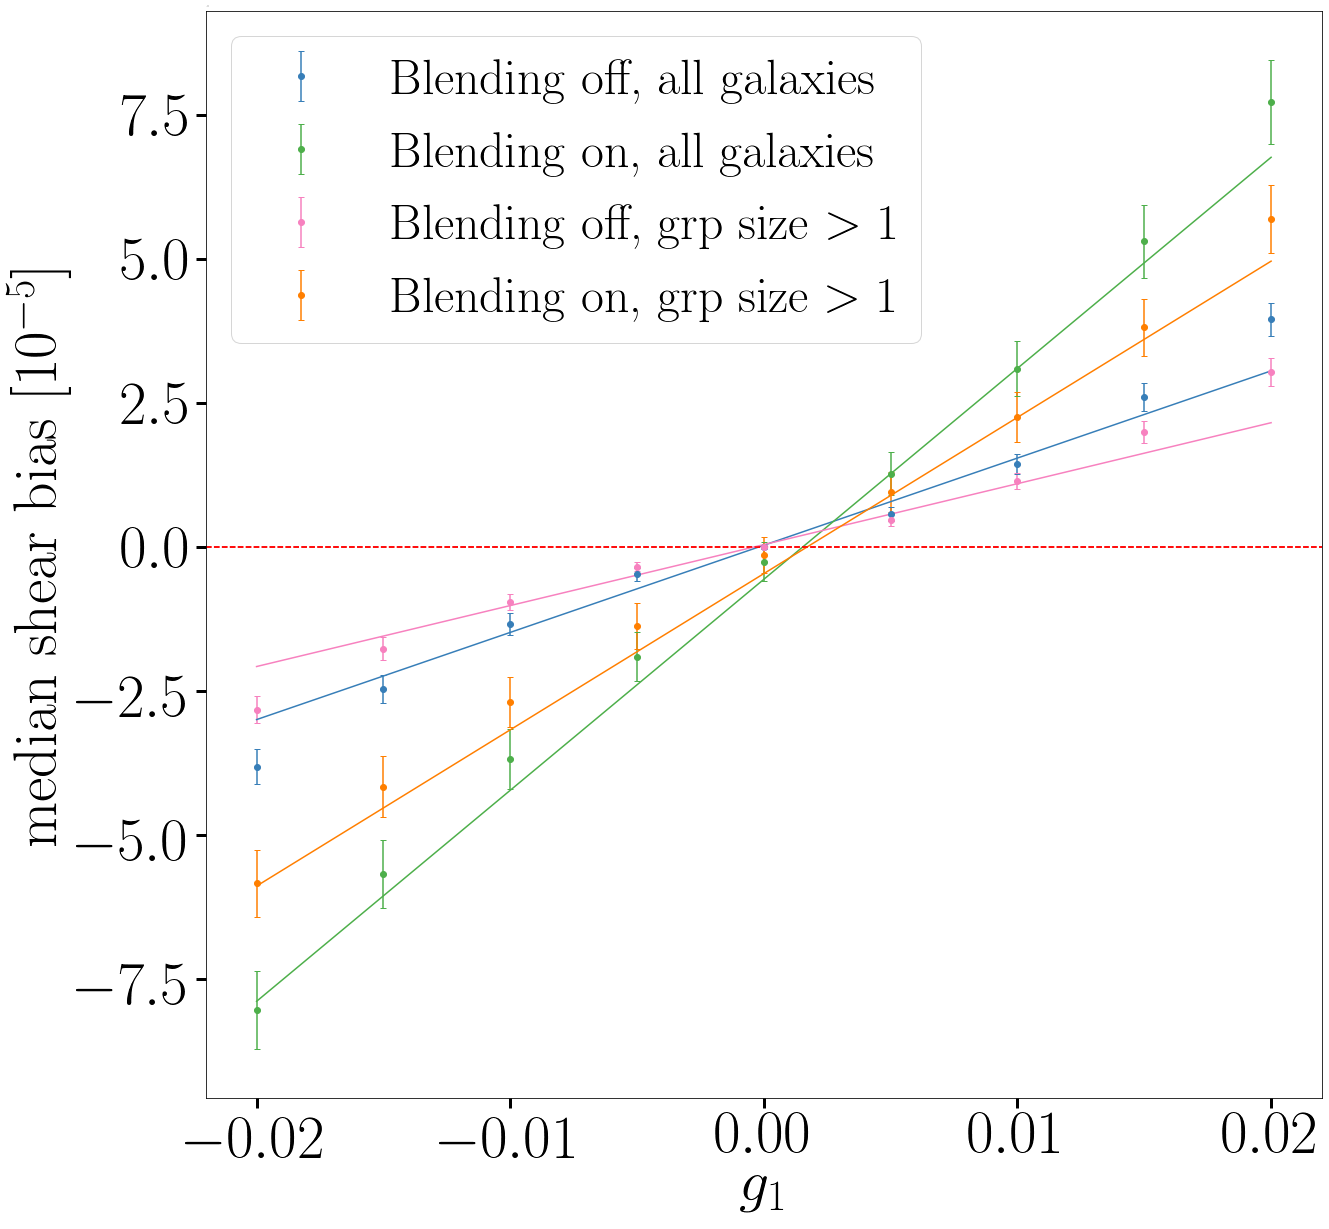

In [31]:
#both 
fig, ax = plt.subplots(figsize=(20,20), nrows = 1, ncols = 1)
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median_prep
inv,inv_grp = np.linalg.inv(cov), np.linalg.inv(cov_grp)
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, inv, inv_grp ,
                      ticks1=None, labely1=None, ax=ax, colors=[blue, green], extra=', all galaxies',
                     legend_size=40, label_size=60, tick_size=60)
print()

betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median2_prep
inv,inv_grp = np.linalg.inv(cov), np.linalg.inv(cov_grp)
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, inv, inv_grp, 
                      ticks1=None, labely1="median shear bias $[10^{-5}]$", ax=ax, colors=[pink, orange], extra=', grp size $>1$',
                     legend_size=50, label_size=60, tick_size=60)

### weighted 

In [14]:
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = weights_prep
print("Weighted noise bias for no applied shear (blending off): {:.3g}, error: {:.3g}".format(values[4], errs[4]))
print("Weighted noise bias for no applied shear (blending on): {:.3g}, error: {:.3g}".format(values_grp[4], errs_grp[4]))

Weighted noise bias for no applied shear (blending off): -0.000258, error: 0.000105
Weighted noise bias for no applied shear (blending on): -0.000276, error: 0.000113


In [ ]:
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, betas, ticks1=None, labely1=None)

### weighted grp size > 1 

Results for fits of unblended case: 


 value b0:     5.287e-02
error b0:     2.834e-04
value b1:     -2.044e-04
error b1:     9.181e-05
error correlation coefficient: -4.464e-03

Results for fits of blended case: 


 value b0:     5.576e-02
error b0:     3.299e-04
value b1:     -2.820e-04
error b1:     1.131e-04
error correlation coefficient: -1.556e-02
Results for fits of unblended case: 


 value b0:     4.614e-02
error b0:     2.635e-04
value b1:     -1.933e-04
error b1:     9.075e-05
error correlation coefficient: -9.548e-03

Results for fits of blended case: 


 value b0:     4.914e-02
error b0:     3.142e-04
value b1:     -2.568e-04
error b1:     1.105e-04
error correlation coefficient: 9.150e-03


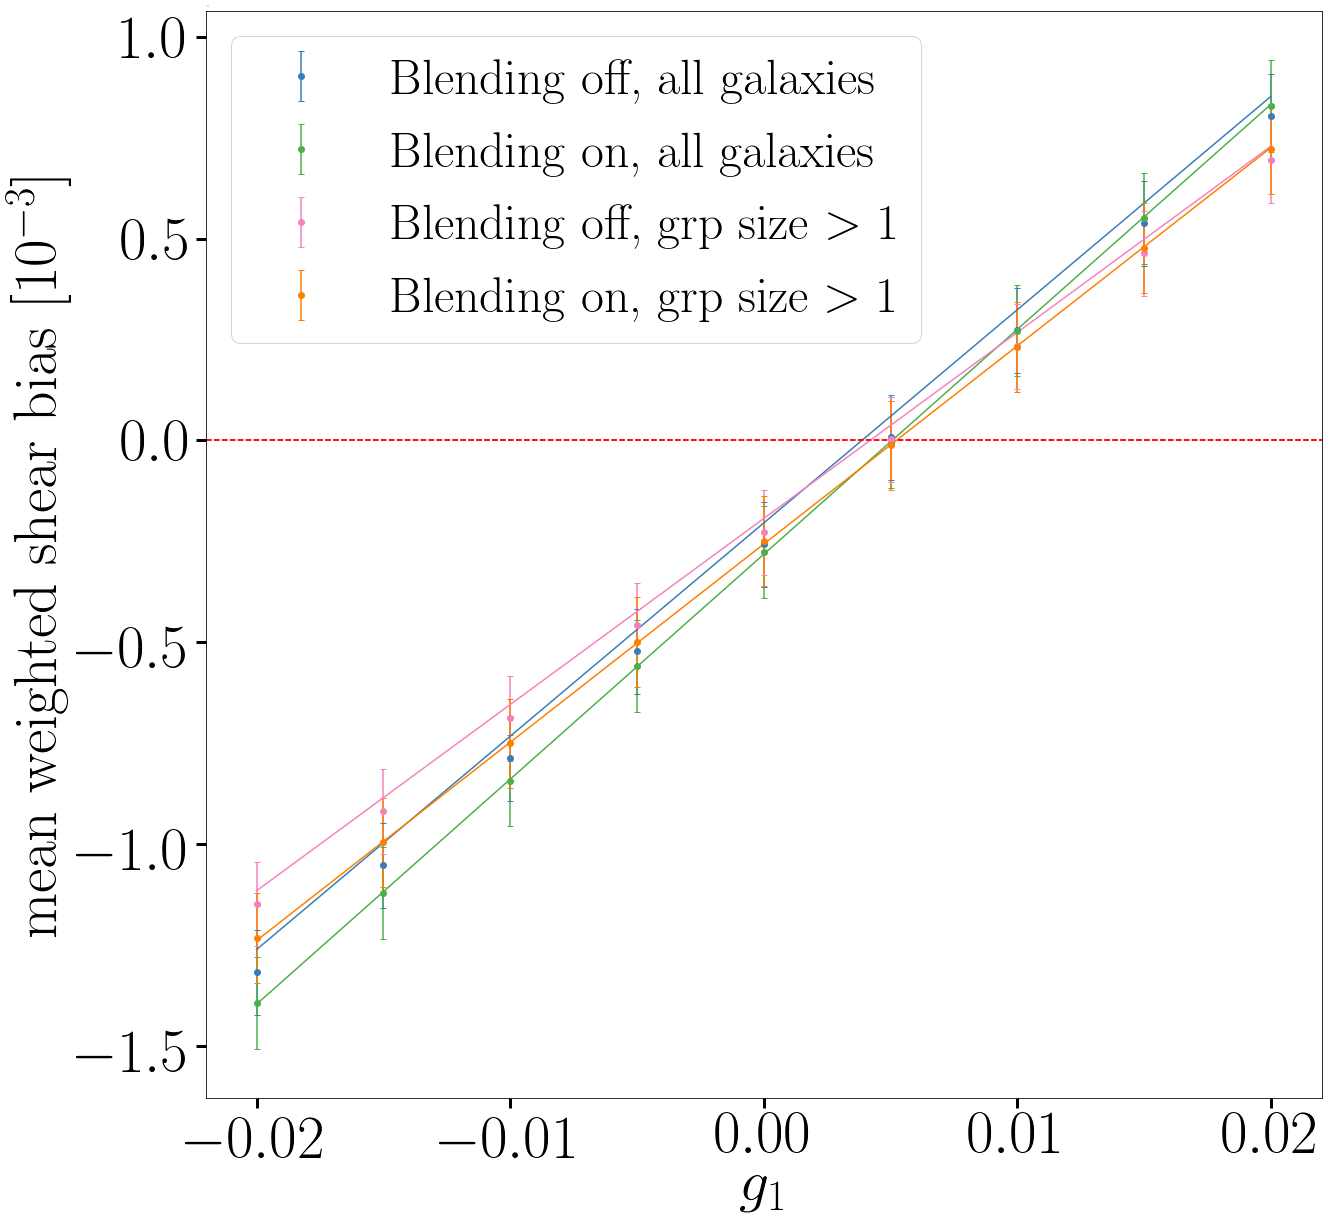

In [32]:
#both 
fig, ax = plt.subplots(figsize=(20,20), nrows = 1, ncols = 1)
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = weights_prep
inv, inv_grp = np.linalg.inv(cov), np.linalg.inv(cov_grp)
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, inv, inv_grp,
                      ticks1=None, labely1=None, ax=ax, colors=[blue, green], extra=', all galaxies',
                     legend_size=40, label_size=50, tick_size=50)


betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = weights2_prep
inv, inv_grp = np.linalg.inv(cov), np.linalg.inv(cov_grp)
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, inv, inv_grp,
                      ticks1=None, labely1="mean weighted shear bias $[10^{-3}]$", ax=ax, 
                      colors=[pink, orange], extra=', grp size $>1$',
                     legend_size=50, label_size=60, tick_size=60)

# Money Plot (high shear) 

In [33]:
g1s = np.array([-0.1, -0.05, -0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1])

In [34]:
orig_ids = list(range(len(fcats2[0])))

## dump

In [79]:
# cov, cov_grp, corr, corr_grp, boot_values, boot_values_grp = money.get_boostrap_covariance_matrix(orig_ids, fcats2, weights.median_fnc, N=1000, args_iso=['1', 'iso'], args_grp=['1', 'grp'], return_bootstraps=True)
# inv, inv_grp = np.linalg.inv(cov), np.linalg.inv(cov_grp)
# values = [weights.median_fnc(orig_ids, cat, *['1', 'iso']) for cat in fcats2]
# betas, param_cov = money.chi_sq_fit(g1s, values, inv, money.cubic_f)
# betas

In [13]:
median_prep = money.prepare_money_plot(g1s, orig_ids, fcats2, weights.median_fnc, fit_procedure=money.chi_sq_fit, 
                         N=int(1e3), model=money.cubic_f, args_iso=['1', 'iso'], args_grp=['1', 'grp'])

In [9]:
weights_prep = money.prepare_money_plot(g1s, orig_ids, fcats2, weights.wmean, fit_procedure=money.chi_sq_fit, 
                                        N=int(1e3), model=money.cubic_f, args_iso=['1', 'iso', 'component'], 
                                        args_grp=['1', 'grp', 'component'])

In [10]:
# pickle.dump(median_prep, open("data/fmedian2_prep.p", 'wb'))
# pickle.dump(weights_prep, open("data/fweights2_prep.p", 'wb'))

In [59]:
fcats22 = [cat[cat['grp_size']>1] for cat in fcats2]
fcats22 = maps.get_intersection_cats(fcats22)
orig_ids2 = list(range(len(fcats22[0])))
median2_prep = money.prepare_money_plot(g1s, orig_ids2, fcats22, weights.median_fnc, fit_procedure=money.chi_sq_fit, 
                         N=int(1e3), model=money.cubic_f, args_iso=['1', 'iso'], args_grp=['1', 'grp'])
weights2_prep = money.prepare_money_plot(g1s, orig_ids2, fcats22, weights.wmean, fit_procedure=money.chi_sq_fit, 
                                        N=int(1e3), model=money.cubic_f, args_iso=['1', 'iso', 'component'], 
                                        args_grp=['1', 'grp', 'component'])



In [60]:
# pickle.dump(median_prep, open("data/fmedian2_prep.p", 'wb'))
# pickle.dump(weights_prep, open("data/fweights2_prep.p", 'wb'))

# pickle.dump(median2_prep, open("data/fmedian2_prep2.p", 'wb'))
# pickle.dump(weights2_prep, open("data/fweights2_prep2.p", 'wb'))

In [13]:
# (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median2_prep
# inv, inv_grp = np.linalg.inv(cov), np.linalg.inv(cov_grp)
# median2_prep = (values, values_grp), (cov, cov_grp, inv, inv_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp)
# pickle.dump(median2_prep, open("data/fweights2_prep2.p", 'wb'))

## read 

In [35]:
median_prep = pickle.load(open("data/fmedian2_prep.p", 'rb'), encoding='latin1')
weights_prep = pickle.load(open("data/fweights2_prep.p", 'rb'), encoding='latin1')

median2_prep = pickle.load(open("data/fmedian2_prep2.p", 'rb'), encoding='latin1')
weights2_prep = pickle.load(open("data/fweights2_prep2.p", 'rb'), encoding='latin1')

## make plots

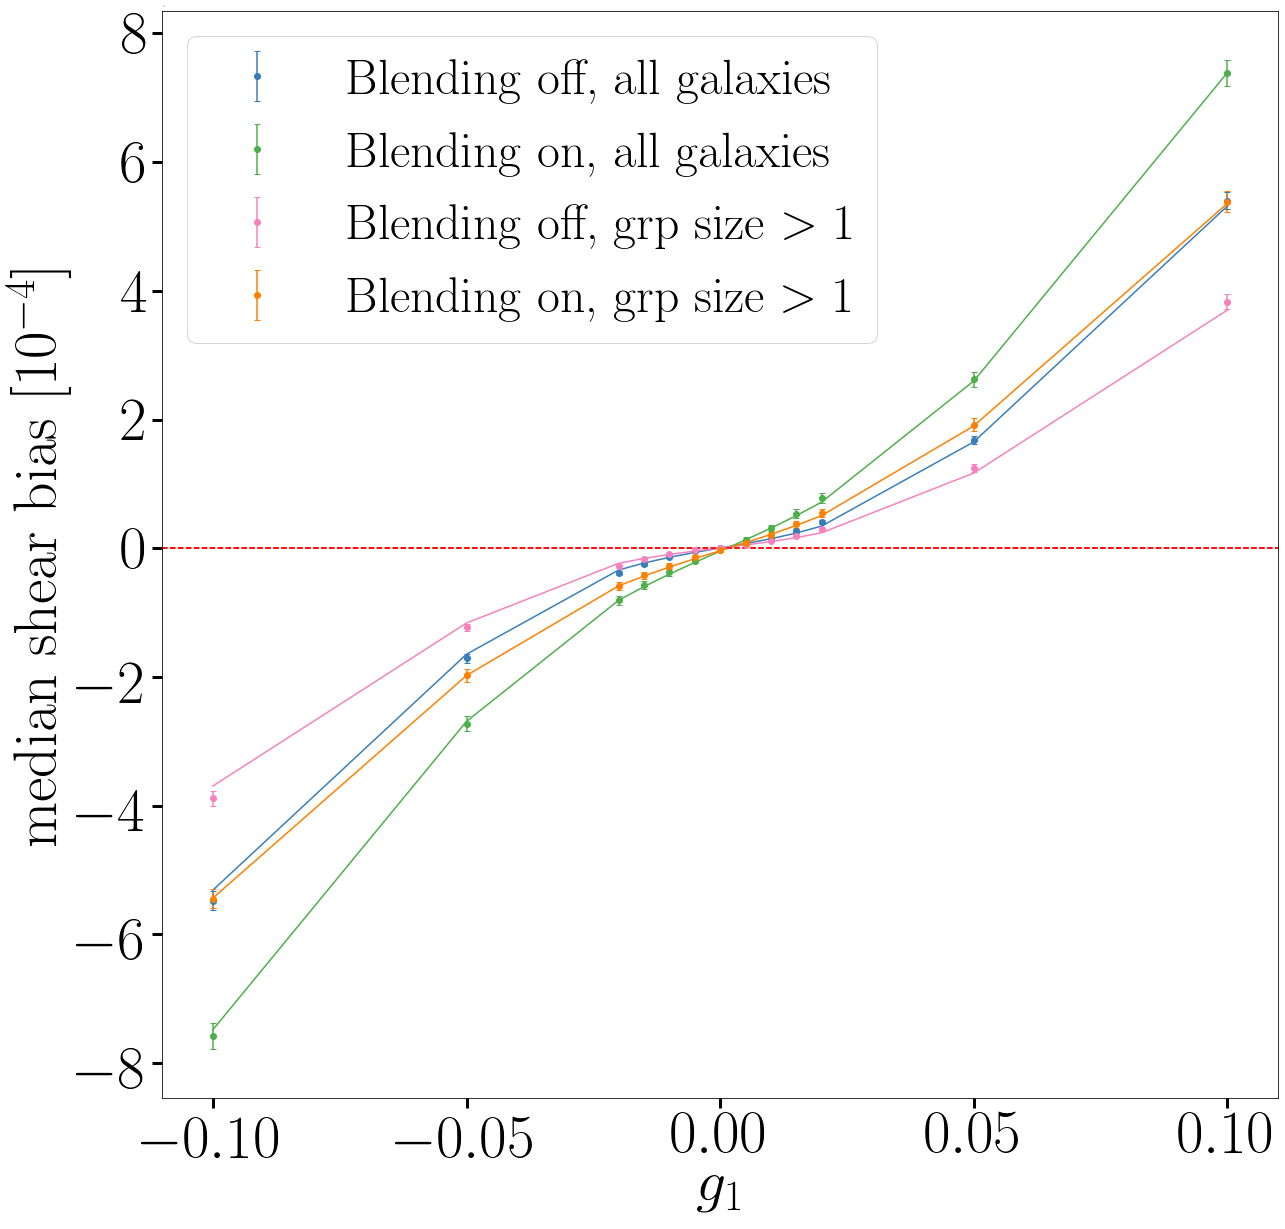

In [27]:
#both 
fig, ax = plt.subplots(figsize=(20,20), nrows = 1, ncols = 1)
(values, values_grp), (cov, cov_grp, inv, inv_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median_prep
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, inv, inv_grp, model=money.penta_f, fit_procedure=money.chi_sq_fit,
                      ticks1=None, labely1=None, ax=ax, colors=[blue, green], extra=', all galaxies',
                     legend_size=40, label_size=50, tick_size=50)
# print()

(values, values_grp), (cov, cov_grp, inv, inv_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median2_prep
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, inv, inv_grp, model=money.penta_f, fit_procedure=money.chi_sq_fit,
                      ticks1=None, labely1="median shear bias $[10^{-4}]$", ax=ax, colors=[pink, orange], extra=', grp size $>1$',
                     legend_size=50, label_size=60, tick_size=60)

In [54]:
reload(money)

<module 'money' from '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD/mycode/money.py'>

Results for fits of unblended case: 


 value b0:     5.188e-02
error b0:     2.348e-04
value b1:     -1.778e-04
error b1:     9.025e-05
error correlation coefficient: -3.227e-03

Results for fits of blended case: 


 value b0:     5.586e-02
error b0:     2.893e-04
value b1:     -2.224e-04
error b1:     1.064e-04
error correlation coefficient: 1.096e-02



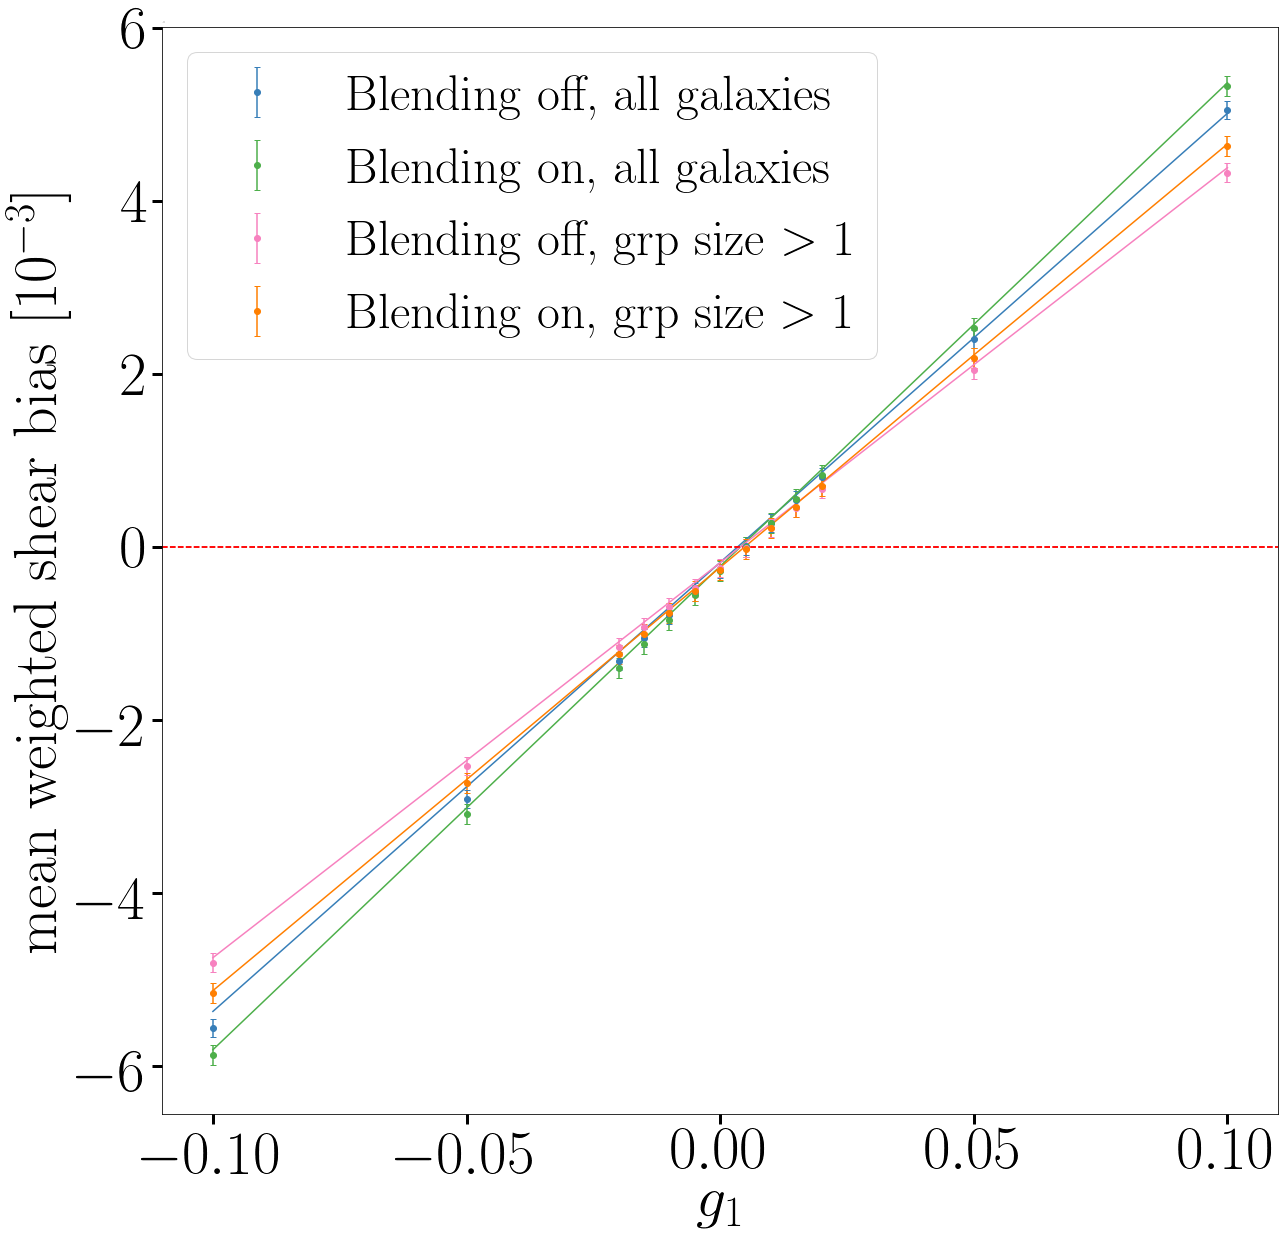

In [37]:
#both 
fig, ax = plt.subplots(figsize=(20,20), nrows = 1, ncols = 1)
(values, values_grp), (cov, cov_grp, inv, inv_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = weights_prep
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, inv, inv_grp, model=money.linear_f, fit_procedure=money.chi_sq_fit,
                      ticks1=None, labely1=None, ax=ax, colors=[blue, green], extra=', all galaxies',
                     legend_size=40, label_size=50, tick_size=50)
print()

(values, values_grp), (cov, cov_grp, inv, inv_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = weights2_prep
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, inv, inv_grp, model=money.penta_f, fit_procedure=money.chi_sq_fit,
                      ticks1=None, labely1="mean weighted shear bias $[10^{-3}]$", ax=ax, colors=[pink, orange], extra=', grp size $>1$',
                     legend_size=50, label_size=60, tick_size=60)

# Tomographic Results

In [10]:
from mycode.tomo import tomo_fncs
reload(tomo_fncs);

In [11]:
g1s = np.array([-0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02])

In [12]:
tomos = np.linspace(0, 1.2, 7)
print(tomos)

[0.  0.2 0.4 0.6 0.8 1.  1.2]


In [13]:
#obtain tomographic catalogues. 
tomo_cats = tomo_fncs.get_tomographic_cats(fcats, tomos)

In [14]:
#functions we need to make this plot. 

import scipy.odr

def linear_f_odr(B, x):
    '''Linear function y = m*x + b'''
    return B[0]*x + B[1]

def glinear_fit(x,y,yerrs):
    linear = scipy.odr.Model(linear_f_odr)
    mydata = scipy.odr.RealData(x, y, sy=yerrs)
    myodr = scipy.odr.ODR(mydata, linear,beta0=[1.,2.])
    myoutput = myodr.run()
    #myoutput.pprint()
    beta0 = myoutput.beta[0]
    beta1 = myoutput.beta[1]
    real_cov_matrix = myoutput.cov_beta* myoutput.res_var
    
    return beta0, beta1, myoutput.sd_beta[0], myoutput.sd_beta[1], real_cov_matrix[0,1]

def make_tomo_plot(median_preps):

    ms = []
    errs_ms = [] 
    ms_grp = []
    errs_ms_grp = []
    for median_prep in median_preps: 
        betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median_prep
        beta0, beta1,beta0_err,beta1_err,beta01_corr = betas[0]
        beta0_grp, beta1_grp,beta0_err_grp,beta1_err_grp,beta01_corr_grp = betas[1]
        
        ms.append(beta0)
        errs_ms.append(beta0_err)
        
        ms_grp.append(beta0_grp)
        errs_ms_grp.append(beta0_err_grp)
    
    
    
    plt.rc('text',usetex=True)
    fig,ax = plt.subplots(figsize=(10,10))
    xs = np.array([np.median(tomo_cats[i][4]['z']) for i in range(len(tomo_cats))])
    
    ax.errorbar(xs, ms, yerr= errs_ms,  color='r', marker='o',linestyle=' ', capsize=2, label= '\\rm{blending off}')
    ax.errorbar(xs, ms_grp, yerr=errs_ms_grp, color='b' , marker='o',linestyle= ' ', capsize=2, label='\\rm{blending on}')
    plt.legend(loc=2, prop={'size':20}) 

    zmax = np.median(tomo_cats[-2][4]['z'])
    
    #do fit and draw the line. 
    #drop the first 'underflow' and last 'overflow' bin for fitting purposes.  
    beta0_iso, beta1_iso,beta0_err_iso,beta1_err_iso,beta01_cov_iso = glinear_fit(xs[1:-1],ms[1:-1],errs_ms[1:-1])
    beta0_grp, beta1_grp,beta0_err_grp,beta1_err_grp,beta01_cov_grp = glinear_fit(xs[1:-1],ms_grp[1:-1],errs_ms_grp[1:-1])

    get_line = lambda x,m,b: m*x + b 
    y_line_iso= get_line(xs,beta0_iso,beta1_iso)
    y_line_grp= get_line(xs,beta0_grp,beta1_grp)

    #do not plot it all the way to the first,last bin.
    ax.plot(xs[1:-1],y_line_iso[1:-1], color='red')
    ax.plot(xs[1:-1],y_line_grp[1:-1], color='blue')

    #plot the last bin dashed 
    ax.plot(xs[-2:],y_line_iso[-2:], color='red', linestyle='dashed')
    ax.plot(xs[-2:],y_line_grp[-2:], color='blue', linestyle='dashed')

    #plot the first bin dashed 
    ax.plot(xs[:2],y_line_iso[:2], color='red', linestyle='dashed')
    ax.plot(xs[:2],y_line_grp[:2], color='blue', linestyle='dashed')
    


    ax.set_xlabel('$z$', size=26)
    ax.set_ylabel('$m \\; [10^{-2}]$', size=26)
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
    ax.get_yaxis().get_offset_text().set_size(1)

    m0_iso = zmax * beta0_iso / 2
    m0_err_iso = beta0_err_iso * zmax /2 
    m0_grp = zmax * beta0_grp / 2
    m0_err_grp = beta0_err_grp * zmax /2 


    m_avg_iso = beta1_iso + m0_iso
    m_avg_iso_err = np.sqrt(beta1_err_iso**2 + m0_err_iso**2)
    m_avg_grp = beta1_grp + m0_grp
    m_avg_grp_err = np.sqrt(beta1_err_grp**2 + m0_err_grp**2)

    corr_iso = ((zmax/2) * beta01_cov_iso + (zmax/2)**2 * beta0_err_iso**2) / np.sqrt(((zmax**2 /4)*beta0_err_iso**2) *(beta1_err_iso**2 + zmax*beta01_cov_iso + (zmax**2/4) * beta0_err_iso**2) )
    corr_grp = ((zmax/2) * beta01_cov_grp + (zmax/2)**2 * beta0_err_grp**2) / np.sqrt(((zmax**2 /4)*beta0_err_grp**2) *(beta1_err_grp**2 + zmax*beta01_cov_grp + (zmax**2/4) * beta0_err_grp**2) )


    print()
    print(f"zmax: {zmax:.3g}")
    print(f"m0 (blending off): {m0_iso:.3g}")
    print(f"m0 err (blending off): {m0_err_iso:.3g}")
    print(f"m_avg (blending off): {m_avg_iso:.3g}")
    print(f"m_avg err (blending off): {m_avg_iso_err:.3g}")
    print(f"correlation (blending off): {corr_iso}")
    print()

    print(f"m0 (blending on): {m0_grp:.3g}")
    print(f"m0 err (blending on): {m0_err_grp:.3g}")
    print(f"m_avg (blending on): {m_avg_grp:.3g}")
    print(f"m_avg err (blending on): {m_avg_grp_err:.3g}")
    print(f"correlation (blending on): {corr_grp}")

## median 

In [16]:
# median_preps = [] 
# for i, cats in enumerate(tomo_cats):
#     print(i)
#     orig_ids = list(range(len(cats[0])))
#     median_preps.append(
#         money.prepare_money_plot(g1s, orig_ids, cats, weights.median_fnc, fit_procedure=money.chi_sq_fit, 
#                          N=int(1e3), model=money.linear_f, args_iso=['1', 'iso'], args_grp=['1', 'grp'])
#     )

# #dump them 
# pickle.dump(median_preps, open("data/median_tomo_preps.p", 'wb'))

0
1
2
3
4
5
6


In [15]:
#load them. 
median_preps = pickle.load(open("data/median_tomo_preps.p", 'rb'), encoding='latin1')


zmax: 1.1
m0 (blending off): 0.00184
m0 err (blending off): 0.000219
m_avg (blending off): 0.000794
m_avg err (blending off): 0.000372
correlation (blending off): -0.4958896851606695

m0 (blending on): 0.00336
m0 err (blending on): 0.000192
m_avg (blending on): 0.00232
m_avg err (blending on): 0.000326
correlation (blending on): -0.4897718526976702


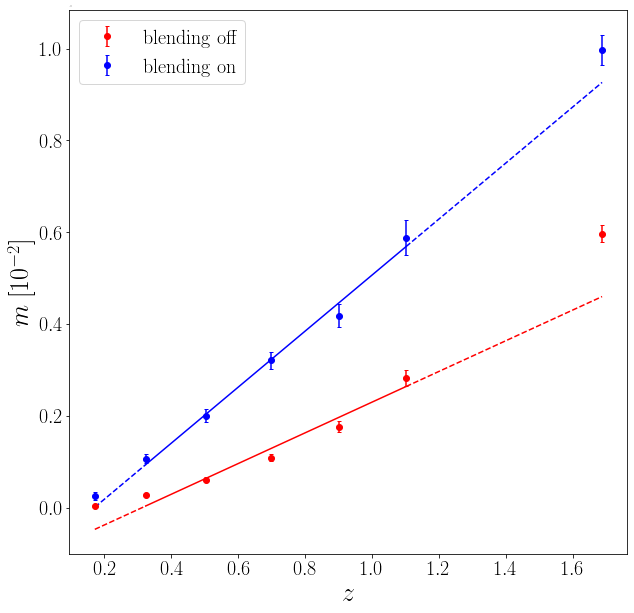

In [16]:
make_tomo_plot(median_preps)

## weight

In [17]:
# weights_preps = [] 
# for i, cats in enumerate(tomo_cats):
#     print(i)
#     orig_ids = list(range(len(cats[0])))
#     weights_preps.append(
#         money.prepare_money_plot(g1s, orig_ids, cats, weights.wmean, fit_procedure=money.chi_sq_fit, 
#                          N=int(1e3), model=money.linear_f, args_iso=['1', 'iso', 'component'], 
#                                  args_grp=['1', 'grp', 'component'])
#     )
    
# pickle.dump(weights_preps, open("data/weights_tomo_preps.p", 'wb'))

0
1
2
3
4
5
6


In [18]:
#load them. 
weights_preps = pickle.load(open("data/weights_tomo_preps.p", 'rb'), encoding='latin1')


zmax: 1.1
m0 (blending off): 0.021
m0 err (blending off): 0.0036
m_avg (blending off): 0.0354
m_avg err (blending off): 0.0061
correlation (blending off): -0.5043788792546692

m0 (blending on): 0.0229
m0 err (blending on): 0.00431
m_avg (blending on): 0.0373
m_avg err (blending on): 0.00729
correlation (blending on): -0.5074584496258662


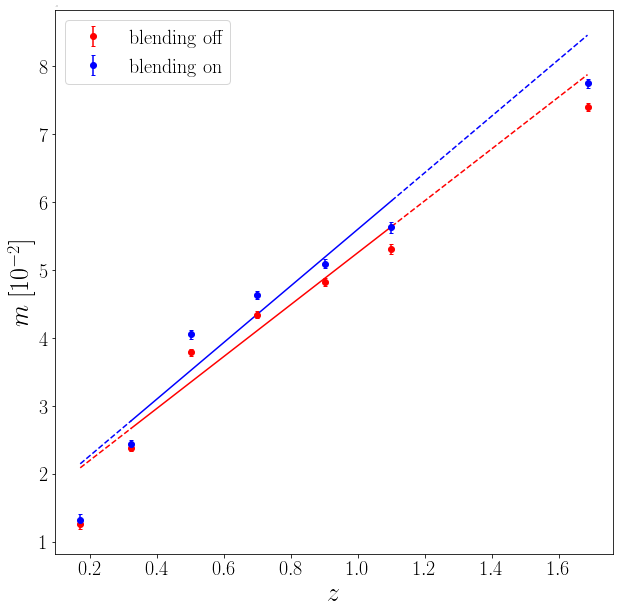

In [19]:
make_tomo_plot(weights_preps)

#  Numbers in text 

In [10]:
cat = cats[4]
fcat = fcats[4]
good_cat = maps.good(cat)
not_dropped_cat = maps.get_not_dropped_cat(cat) 


In [13]:

############################
print(f"Total number of galaxies: {len(cats[4])}")

x = len(cat[(cat['snr_grpf'] > 6)&(cat['purity'] > 0.98)]) / len(cat)
print("Total fraction of events that are detectable and have high purity: {:.3g}% \n".format(x*100))

x = len(cat[cat['ab_mag'] < 25.3]) / len (cat)
print("Total fraction of events that are in gold sample: {:.3g}% \n".format(x*100))


x1 = (len(cat) - len(not_dropped_cat)) / len(cat)
y1 = (len(set(cat['grp_id'])) - len(set(not_dropped_cat['grp_id']))) / len(set(cat['grp_id']))
print("{:.3g}% of galaxies are parts of groups with at least one galaxy dropped, \
{:.3g}% of groups have at least one dropped galaxy. \n".format(x1*100, y1*100))

x = len(maps.good(cat)) /len(cat)
print("{:.3g}% of galaxies satisfy criteria for lensing sample. \n".format(x*100))

x1 = len(maps.detected(good_cat)) / len(good_cat)
y1 = len(maps.detc_and_notambig(good_cat)) / len(good_cat)
y2 = len(maps.detc_and_ambig(good_cat)) / len(good_cat)
x2 = 1 - x1 
y3 = len(maps.notdetc_and_notambig(good_cat)) / len(good_cat)
y4 = len(maps.notdetc_and_ambig(good_cat)) / len(good_cat)
print("Out of the galaxies that satisfy the criteria for the lensing sample, {:.3g}% are detected -- {:.3g}% \
with no close overlaps and {:.3g}% with close overlaps; {:.3g}% are not detected -- {:.3g}% with no close overlaps \
and {:.3g}% with close overlaps. \n ".format(x1*100, y1*100, y2*100, x2*100, y3*100, y4*100))

x = len(fcat) / len(cat)
print("{:.3g}% will be used for fisher analysis, or {:.3g} of galaxies".format(x*100, len(fcat)))

x = len(fcat[fcat['grp_size']>1])/len(fcat)
print("Out of the galaxies that will be used for fisher analysis, {:.3g}% have a group size > 1".format(x*100))


Total number of galaxies: 802101
Total fraction of events that are detectable and have high purity: 16% 

Total fraction of events that are in gold sample: 22.5% 

0.259% of galaxies are parts of groups with at least one galaxy dropped, 0.0525% of groups have at least one dropped galaxy. 

18.1% of galaxies satisfy criteria for lensing sample. 

Out of the galaxies that satisfy the criteria for the lensing sample, 93.2% are detected -- 77.9% with no close overlaps and 15.4% with close overlaps; 6.79% are not detected -- 4.79% with no close overlaps and 2% with close overlaps. 
 
14% will be used for fisher analysis, or 1.13e+05 of galaxies
Out of the galaxies that will be used for fisher analysis, 85.6% have a group size > 1


# Equilibration

## Statement on condition numbers

In [12]:
no_equil_cat = maps.get_filter_cats(
    [Table.read("data/no_equilibration1_LSST-g1_0-g2_0/final_fits.fits")], pfilters)[0] 

In [13]:
group_ids1 = set()
cond_num_grps1 = [] 
for row in no_equil_cat: 
    if not row['grp_id'] in group_ids1: 
        group_ids1.add(row['grp_id'])
        cond_num_grps1.append(row['cond_num_grp'])
cond_num_grps1 = np.log10(np.array(cond_num_grps1))

group_ids2 = set()
cond_num_grps2 = [] 
for row in cats[4]: 
    if not row['grp_id'] in group_ids2: 
        group_ids2.add(row['grp_id'])
        cond_num_grps2.append(row['cond_num_grp'])
cond_num_grps2 = np.log10(np.array(cond_num_grps2))

In [14]:
x=3
print(f"{x:.2f}")

3.00


In [14]:
result = len(cond_num_grps1[cond_num_grps1 > 13]) / len(cond_num_grps1)
print(f"Fraction of condition numbers that are bigger than 1e13 before equilibration: {0.2df}")


Condition numbers that are bigger than 1e13 before equilibration


0.08391925139745318

In [15]:
print("Fraction of condition numbers that are bigger than 1e13 after equilibration")
len(cond_num_grps2[cond_num_grps2 > 13]) / len(cond_num_grps2)

Condition numbers that are bigger than 1e13 after equilibration


0.00023333779420292838